In [1]:
from cnn import SegmentationModel as net
from DataSet import CamVidDataset

from d2l import torch as d2l
from tqdm import tqdm
import pandas as pd
import monai
from torchcontrib.optim import SWA
import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from IOUEval import iouEval
import time


d:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
d:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
d:\Anaconda\lib\site-pa

In [2]:

model = net.EESPNet_Seg(2)
 
train_path = "C:/Users/asus/Desktop/Video Substraction/DAVIS/ImageSets/480p/train.txt"
val_path   = "C:/Users/asus/Desktop/Video Substraction/DAVIS/ImageSets/480p/trainval.txt"
root_path  = 'C:/Users/asus/Desktop/Video Substraction/DAVIS'


train_dataset = CamVidDataset(train_path,root_path)
val_dataset = CamVidDataset(val_path,root_path)

 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,drop_last=True)
# training loop 100 epochs
epochs_num = 50
# 选用SGD优化器来训练

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
schedule = monai.optimizers.LinearLR(optimizer, end_lr=0.05, num_iter=int(epochs_num*0.75))
# 使用SWA优化 来提升SGD的效果

steps_per_epoch = int(len(train_loader.dataset) / train_loader.batch_size)
swa_start = int(epochs_num*0.75)
optimizer = SWA(optimizer, swa_start=swa_start*steps_per_epoch, swa_freq=steps_per_epoch, swa_lr=0.05)
 
# 损失函数选用多分类交叉熵损失函数
lossf = nn.CrossEntropyLoss(ignore_index=255)
 
 


In [3]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
 
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            output = net(X)
            pred = output[0]
            metric.add(d2l.accuracy(pred, y), d2l.size(y))
    return metric[0] / metric[1]
 
 


In [4]:
# 训练函数
def train_ch13(output_dir,net, train_iter, test_iter, loss, optimizer, num_epochs, schedule, swa_start=swa_start, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 用来保存一些训练参数
 
    loss_list = []
    train_acc_list = []
    test_acc_list = []
    epochs_list = []
    time_list = []
    lr_list = []
    mIOU_list=[]
    total_batches = len(train_iter)
    iouEvalTrain = iouEval(2)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (X, labels) in enumerate(train_iter):
            a = timer.start()
 
            if isinstance(X, list):
                X = [x.to(devices[0]) for x in X]
            else:
                X = X.to(devices[0])
            gt = labels.long().to(devices[0])
            # print(X.shape)
            net.train()
            optimizer.zero_grad()
            output1,output2 = net(X)
            loss1 = loss(output1, gt)
            loss2 = loss(output2, gt)
            loss_sum = loss1+loss2
            
            loss_sum.backward()
            optimizer.step()
 
            iouEvalTrain.addBatch(output1.max(1)[1].data, gt)
            
            b = timer.stop()
            print('[%d/%d] loss: %.3f time: %.2f' % (i, total_batches, loss_sum.item(),timer.sum() ))
        overall_acc, per_class_acc, per_class_iu, mIOU = iouEvalTrain.getMetric()
        loss_list.append(loss_sum.item())
        train_acc_list.append(overall_acc)
        mIOU_list.append(mIOU)
        if optimizer.state_dict()['param_groups'][0]['lr']>0.05:
            schedule.step()
 
        
        
        if (epoch + 1) >= swa_start:
            if epoch == 0 or epoch % 5 == 5 - 1 or epoch == num_epochs - 1:
                # Batchnorm update
                optimizer._reset_lr_to_swa()
                optimizer.swap_swa_sgd()
                optimizer.bn_update(train_iter, net, device='cuda')
                
                optimizer.swap_swa_sgd()
        
        animator.add(epoch + 1, (None, None, overall_acc))
 
        print(f"epoch {epoch+1}/{epochs_num} --- train acc {overall_acc:.3f} --- mIOU {mIOU:.3f} --- cost time {timer.sum()}")
        
        #----------------保存模型------------------- 
        if np.mod(epoch+1, 5) == 0:
            torch.save(net.state_dict(), output_dir+ f'checkpoints/ESPNetv2_{epoch+1}.pth')
 
    # 保存下最后的model
    torch.save(net.state_dict(), output_dir +  f'checkpoints/ESPNetv2_last.pth')
 


In [5]:
output_dir = "C:/Users/asus/Desktop/Video Substraction/Output/"

TypeError: __call__() got an unexpected keyword argument 'image'

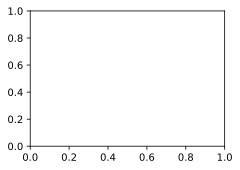

In [6]:
loss_list,acc_list,mIOU_list = train_ch13(output_dir,model, train_loader, val_loader, lossf, optimizer, epochs_num, schedule=schedule)

In [ ]:
from thop import profile
model = model.cuda()
input = torch.randn(16, 3,448, 448).cuda() # (batch_size, num_channel, Height, Width)
flops, params = profile(model, inputs=(input, )) 
print('flops: {}, params: {}'.format(flops, params))
